# Example: Optimize Synthetic Data Generation

This example demonstrates how to tune the synthetic data generation pipeline to match real microscopy images using embedding-based optimization.

**Note**: Before running this notebook, ensure you have installed the necessary dependencies as described in the [Installation section of the README](https://github.com/ml-lab-htw/SynthMT#installation). Running this notebook takes ~10 min.

## Overview

The optimization process works as follows:
1. **Real reference images** (unlabeled) define the target distribution $Q$
2. **Synthetic images** are generated by the parametric generator $P_\theta$
3. Both real and synthetic images are embedded using **DINOv2**, a pre-trained vision transformer
4. The parameters $\theta$ are iteratively refined to **maximize cosine similarity** between real and synthetic embeddings

This allows the synthetic data to match the statistical properties and visual characteristics of experimental data—without requiring ground-truth annotations.

![Data Generation Pipeline](images/data_gen_overview.png)

*Figure: Optimizing θ aligns synthetic image distributions with real, annotation-free microscopy data.*

In [2]:
import os
from functools import partial

# When on MPS (Apple Silicon), you might need to do:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import optuna
from matplotlib import pyplot as plt

from synth_mt.plotting import create_overlay
from synth_mt.config.synthetic_data import SyntheticDataConfig
from synth_mt.config.tuning import TuningConfig
from synth_mt.data_generation.optimization.embeddings import ImageEmbeddingExtractor
from synth_mt.data_generation.optimization.eval import evaluate_synthetic_data_cfg
from synth_mt.data_generation.optimization.metrics import precompute_matric_args
from synth_mt.data_generation.optimization.objective import objective

## Load Tuning Configuration

The tuning configuration specifies the reference images, search space for parameters, and optimization settings.

In [3]:
cfg_path = "tuning_config_example.json"
tuning_cfg = TuningConfig.load(cfg_path)
tuning_cfg.validate()

## Compute Reference Embeddings

Extract DINOv2 embeddings from the real reference images. These embeddings define the target distribution that synthetic images should match.

In [4]:
embedding_extractor = ImageEmbeddingExtractor(tuning_cfg)
ref_embeddings = embedding_extractor.extract_from_references()
precomputed_kwargs = precompute_matric_args(tuning_cfg, ref_embeddings)

Processing reference images:   0%|          | 0/3 [00:00<?, ?it/s]/Users/jw/miniforge3/envs/synth_mt/lib/python3.11/site-packages/torch/nn/functional.py:4594: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1744320346501/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(
Processing reference images: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


## Setup Optuna Study

We use Optuna with TPE (Tree-structured Parzen Estimator) sampler to efficiently search the parameter space. Results are stored in a SQLite database for persistence.

In [5]:
db_filename = f"{tuning_cfg.output_config_id}.db"
db_filepath = os.path.join(tuning_cfg.temp_dir, db_filename)

os.makedirs(tuning_cfg.temp_dir, exist_ok=True)
storage_uri = f"sqlite:///{db_filepath}"

In [6]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(),
    study_name=tuning_cfg.output_config_id,
    storage=storage_uri,
    direction=tuning_cfg.direction,
    load_if_exists=tuning_cfg.load_if_exists,
)

# Use partial to pass the pre-computed objects to the objective function
objective_fcn = partial(
    objective,
    tuning_cfg=tuning_cfg,
    ref_embeddings=ref_embeddings,
    embedding_extractor=embedding_extractor,
    **precomputed_kwargs,
)

[I 2026-01-21 15:23:49,819] A new study created in RDB with name: example


## Run Optimization

Each trial samples parameters $\theta$, generates synthetic images, computes their embeddings, and measures similarity to the reference embeddings.

In [7]:
study.optimize(objective_fcn, n_trials=tuning_cfg.num_trials)

[I 2026-01-21 15:24:00,105] Trial 0 finished with value: 0.8977500796318054 and parameters: {'base_segment_length_min': 9.782930788473257, 'base_segment_length_max': 43.404894711753975, 'microtubule_length_min': 97, 'microtubule_length_max': 136, 'tail_segment_length': 12.814445472394784, 'bending_angle_gamma_shape': 1.5073111177216632, 'bending_angle_gamma_scale': 0.03186533973834859, 'max_angle_sign_changes': 8, 'minus_end_target_length_std': 1.762862098207917, 'minus_end_target_length_mean': -0.9346226922758833, 'prob_to_flip_bend': 0.07992232315182295, 'num_microtubule': 6, 'psf_sigma_h': 0.40747079738409714, 'psf_sigma_v': 0.7280709548095492, 'tubule_width_variation': 0.10765659866565709, 'background_level': 0.8700795396528358, 'tubulus_contrast': -0.31209363879122043, 'seed_red_channel_boost': 0.21021795421070635, 'tip_brightness_factor': 1.0338549125888203, 'red_channel_noise_std': 0.07164774039323445, 'quantum_efficiency': 103.69350464790793, 'gaussian_noise': 0.347876593241245

## Visualize Optimization Results

/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_9927/1625114509.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_optimization_history(study)


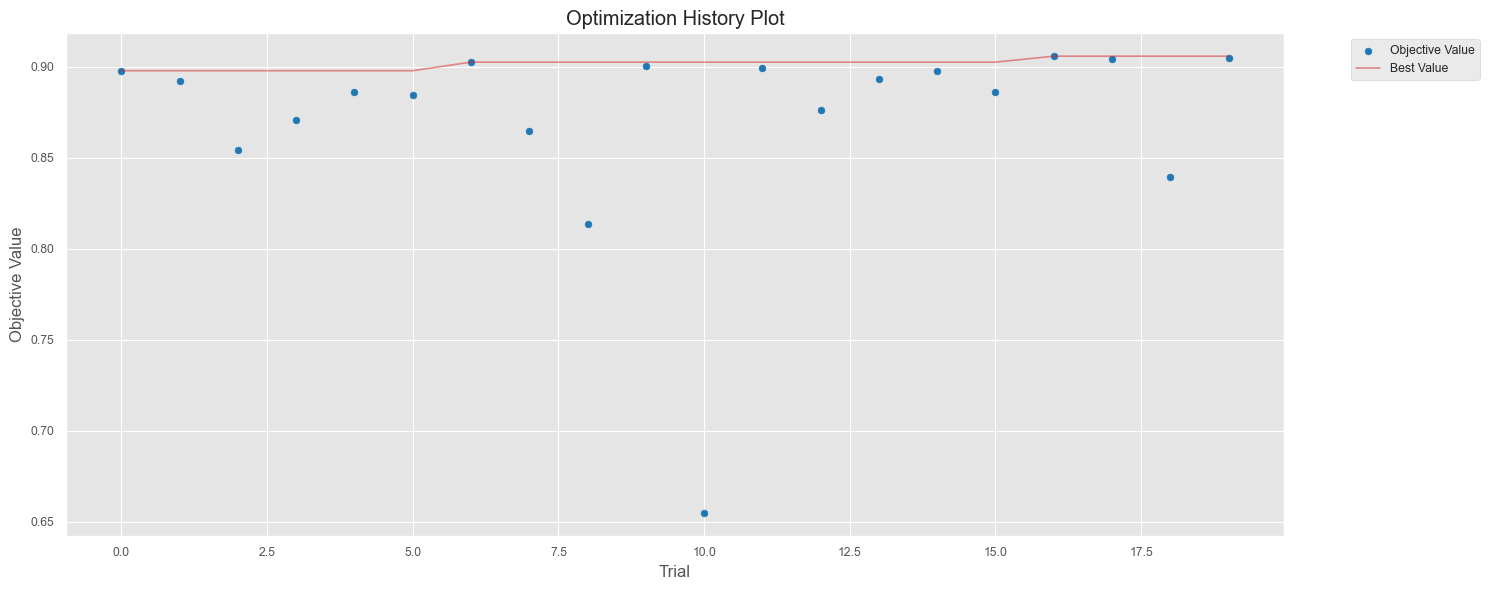

In [11]:
%matplotlib inline

ax = optuna.visualization.matplotlib.plot_optimization_history(study)
fig = ax.figure
fig.set_size_inches(15, 6)

/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_9927/3738551205.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_param_importances(study)


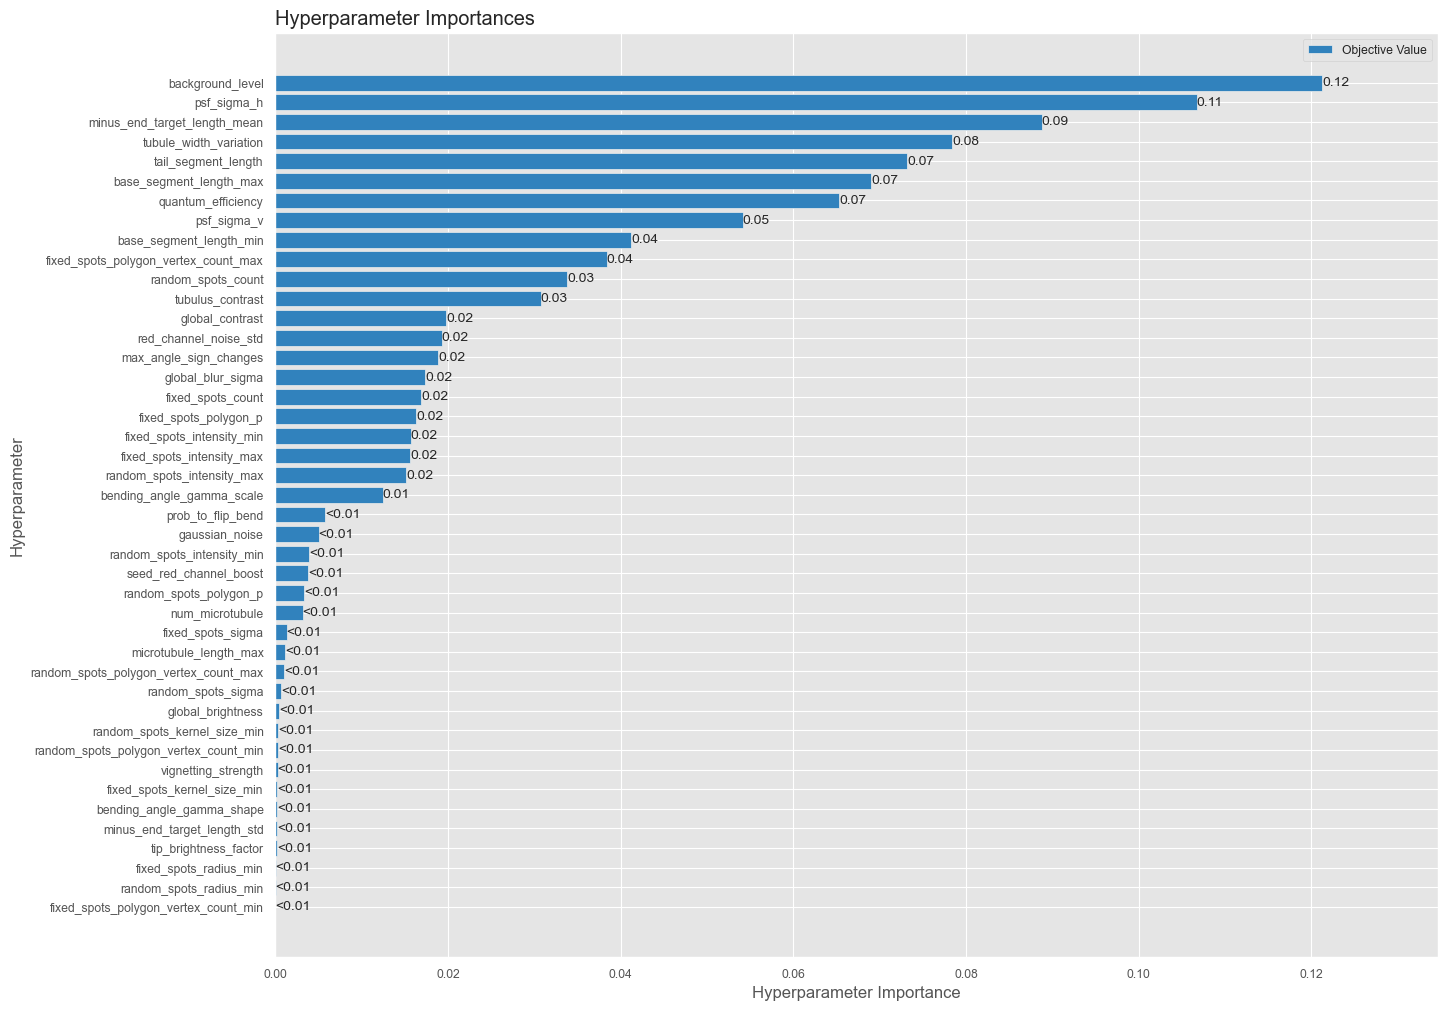

In [12]:
ax = optuna.visualization.matplotlib.plot_param_importances(study)
fig = ax.figure
fig.set_size_inches(15, 12)

## Extract Best Configurations

Select the top-performing parameter configurations and generate sample images for validation.

In [13]:
# Choose top-N
top_n = tuning_cfg.output_config_num_best
top_trials = []

trials = study.trials
sorted_trials = sorted(
    [t for t in trials if t.value is not None], key=lambda t: t.value, reverse=True
)
number_of_trials = len(sorted_trials)
top_trials = sorted_trials[:top_n]

In [14]:
frames = []
masks = []
for i, trial in enumerate(top_trials):

    current_cfg = SyntheticDataConfig.from_trial(trial)
    current_cfg.num_frames = tuning_cfg.output_config_num_frames

    current_frames, current_masks = evaluate_synthetic_data_cfg(
        cfg=current_cfg,
        tuning_cfg=tuning_cfg,
        output_dir=None,
        is_for_expert_validation=False,
    )

    frames.append(current_frames)
    masks.append(current_masks)

## Visualize Generated Samples from Best Trials with Overlays

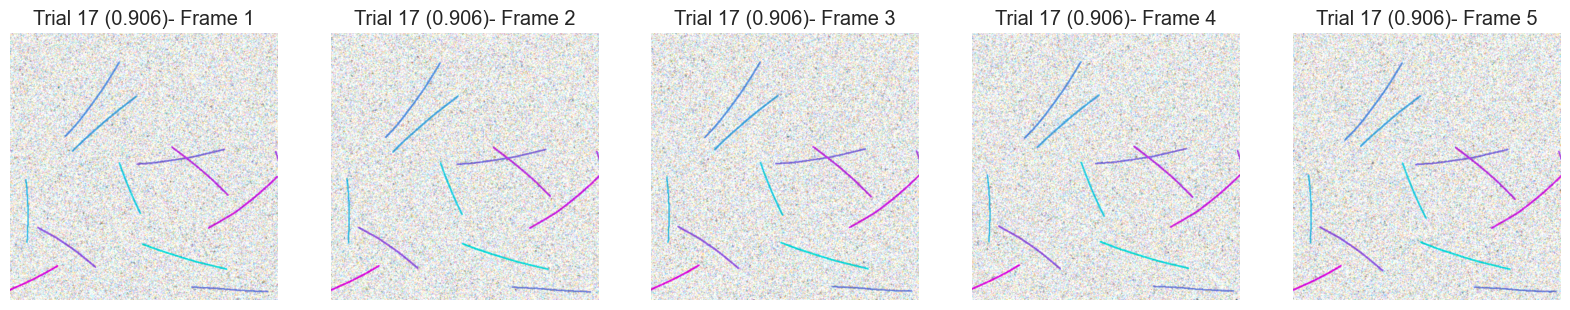

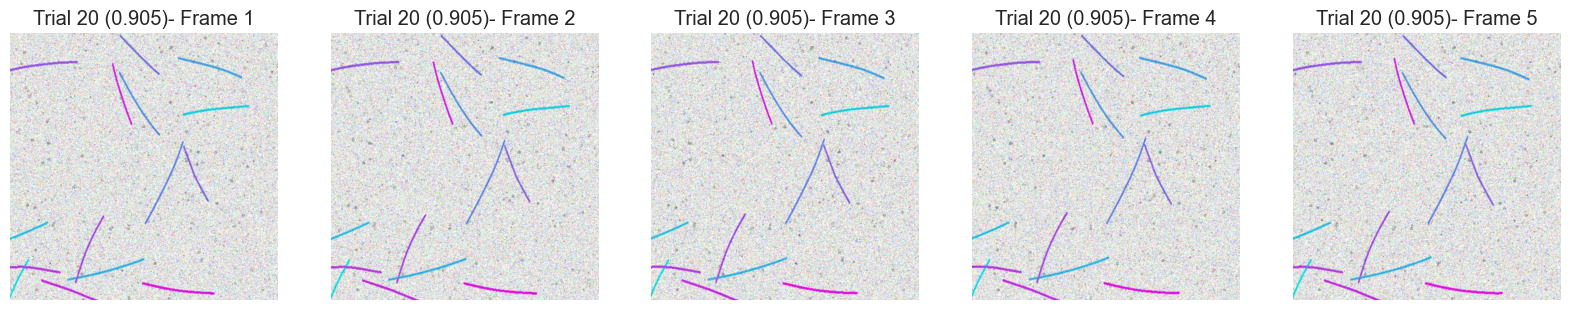

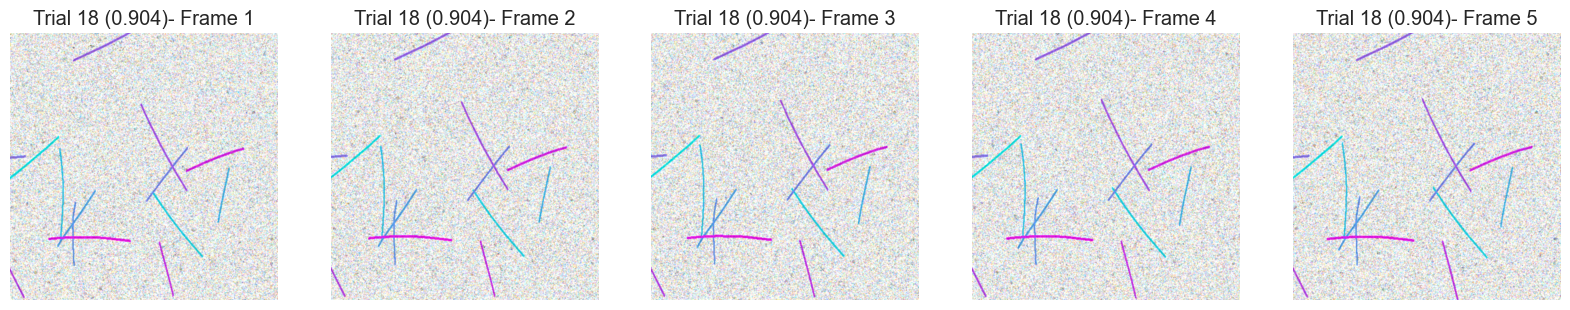

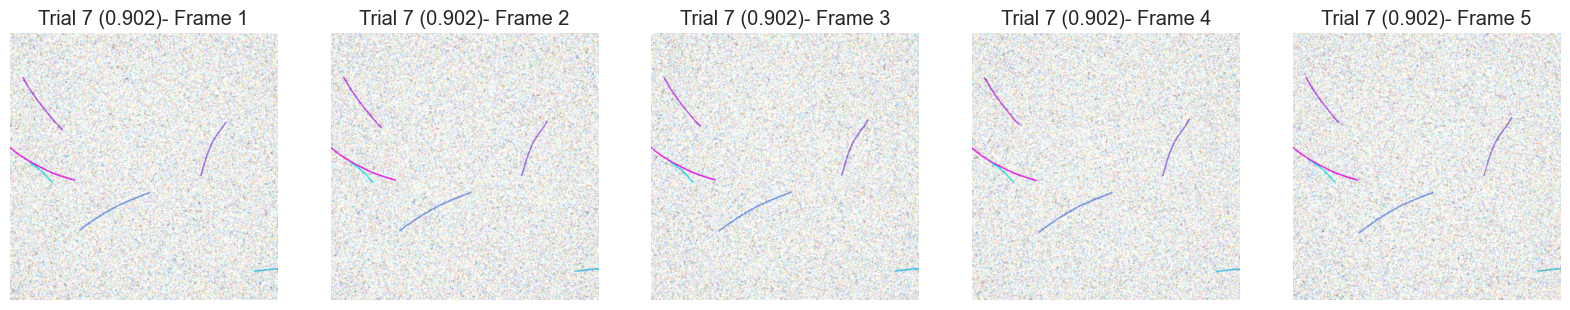

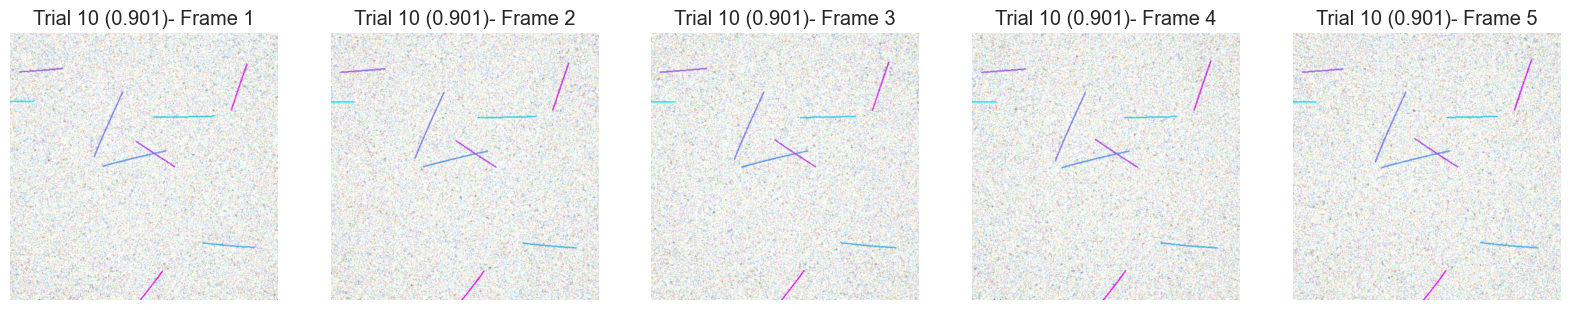

In [15]:
for current_frames, current_masks, trial in zip(frames, masks, top_trials):
    fig, axs = plt.subplots(1, 5, figsize=(20, 10))
    axs = axs.flatten()

    for ax, idx in zip(axs, range(len(frames))):
        overlay = create_overlay(current_frames[idx], current_masks[idx])

        ax.imshow(overlay)
        ax.axis("off")
        ax.set_title(f"Trial {trial.number+1} ({trial.value:.3f})- Frame {idx+1}")